### Laboratorium 6 - część projektowa

W tej części zajmiesz się wykorzystaniem punktów kluczowych do łączenia obrazów (_image stitching_). Celem zadania jest przetestowanie możliwości detekcji i parowania punktów kluczowych w celu łączenia obrazów. Istotne jest, by samodzielnie przejść całą ścieżkę: od detekcji punktów kluczowych i wyznaczenia ich desktryptorów, przez ich parowanie i znalezienie transformacji, po finalne połączenie obrazów. Rozwiązania oparte o gotowce w stylu black-box nie będą oceniane.

Wykonaj serię zdjęć dowolnej wybranej przez siebie **statycznej** sceny. Może to być niemal dowolny widok o dowolnej skali: panorama miasta, swojego pokoju, powierzchni biurka - ważne, by pozyskane obrazy umożliwiały (1) użycie algorytmu SIFT, oraz (2) wykonanie transformacji geometrycznej.

Wykonaj 4-5 zdjęć, spośród których pierwsze (nazwij je `base`) niech przedstawia \"główny\" widok sceny, a pozostałe (o nazwie `offset_{index}`) niech cechują się coraz większym przesunięciem kamery względem `base`. Proponowane różnice:
* nieznaczne przesunięcie (o ~połowę szerokości klatki),
* większe przesunięcie (o 3/4 szerokości lub więcej),
* przesunięcie z rotacją w osi kamery,
* (jeśli to możliwe) przybliżenie/oddalenie kamery.

Wykorzystaj algorytmy opracowane do realizacji zadania 3 (zwłaszcza 3b) w celu przekształcania obrazów `offset_x` do geometrii `base`. Upewnij się, że wymiary wynikowych obrazów są wystarczające do zmieszczenia obu składowych.

*Czy każdą parę `offset_i`-`base` udało się połączyć? Jeśli dla którejś pary metoda zawiodła, to dlaczego?*  
*Jaka była jakość dopasowania? Na jakiej podstawie ją określasz?*

In [65]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

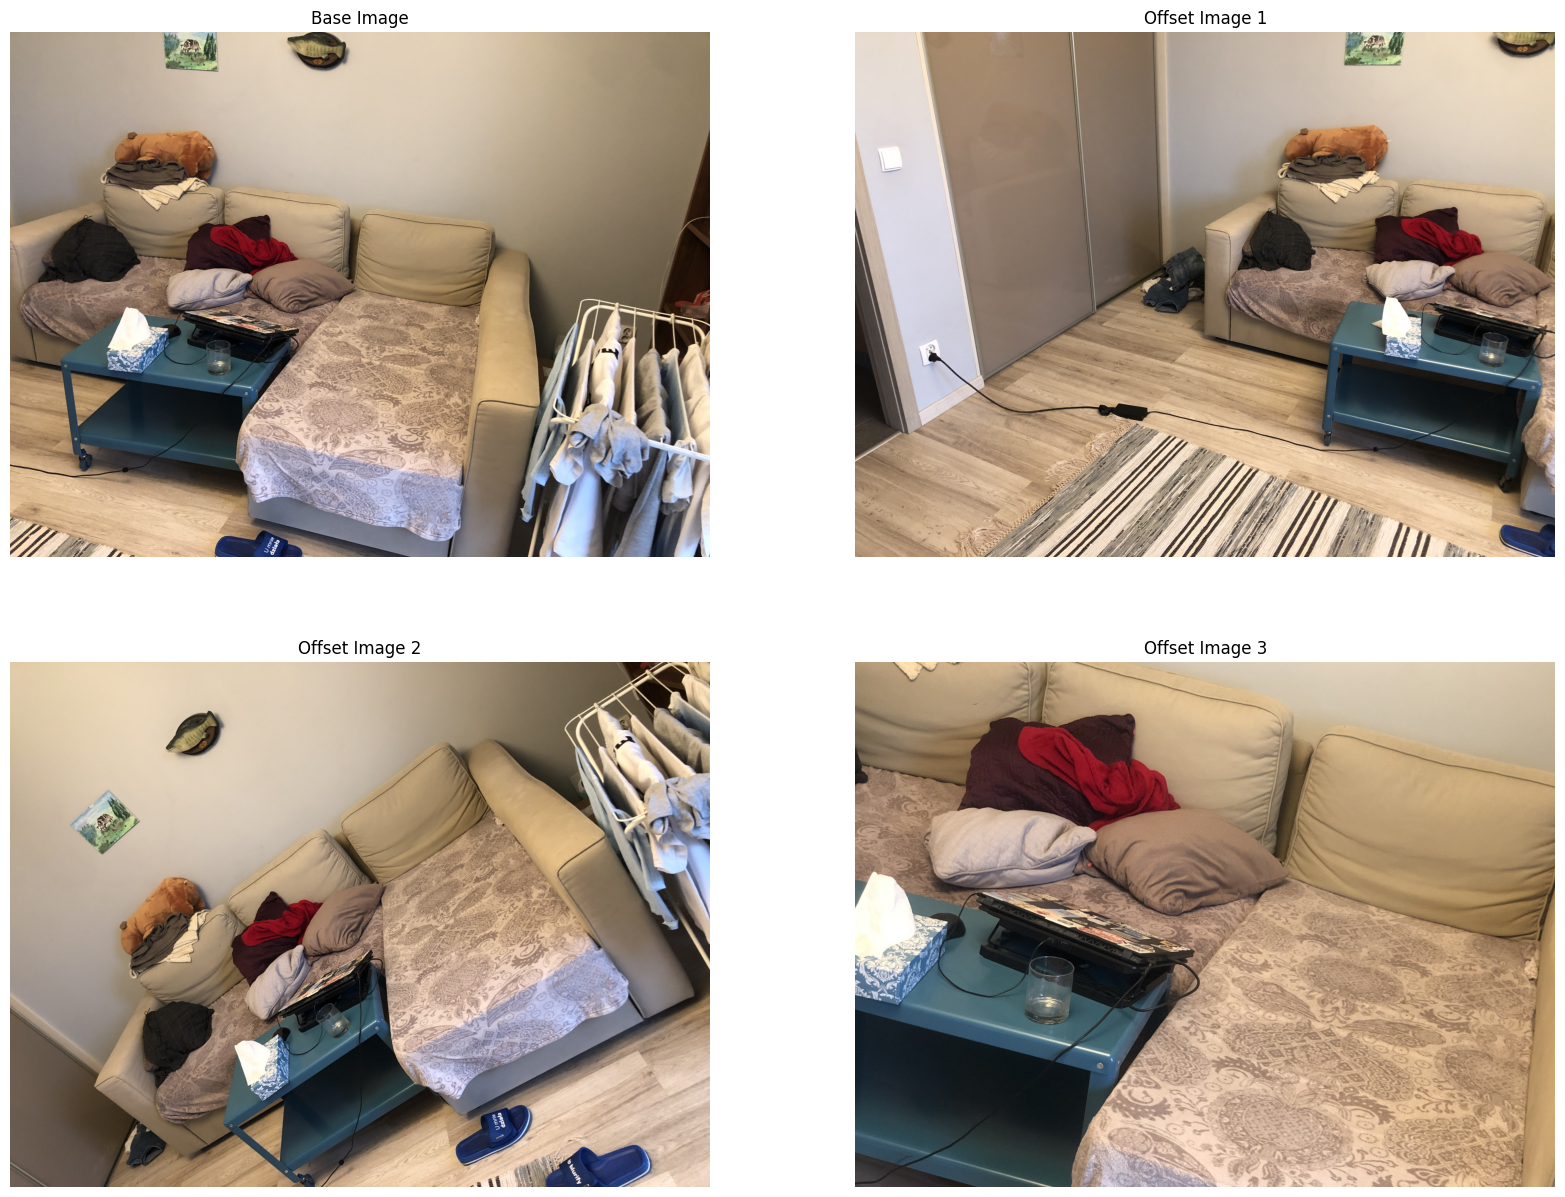

In [66]:
base_img = cv2.imread("base.jpg")
base_img = cv2.resize(base_img, (0, 0), fx=0.5, fy=0.5)
offset_imgs = []
for i in [1, 2, 3]:
    offset_img = cv2.imread(f"offset_{i}.jpg")
    offset_img = cv2.resize(offset_img, (0, 0), fx=0.5, fy=0.5)
    offset_imgs.append(offset_img)

fig, ax = plt.subplots(2, 2, figsize=(20, 15))
ax = ax.flatten()
ax[0].imshow(cv2.cvtColor(base_img, cv2.COLOR_BGR2RGB))
ax[0].set_title("Base Image")
ax[0].axis("off")
for i in range(3):
    ax[i + 1].imshow(cv2.cvtColor(offset_imgs[i], cv2.COLOR_BGR2RGB))
    ax[i + 1].set_title(f"Offset Image {i+1}")
    ax[i + 1].axis("off")
plt.show()

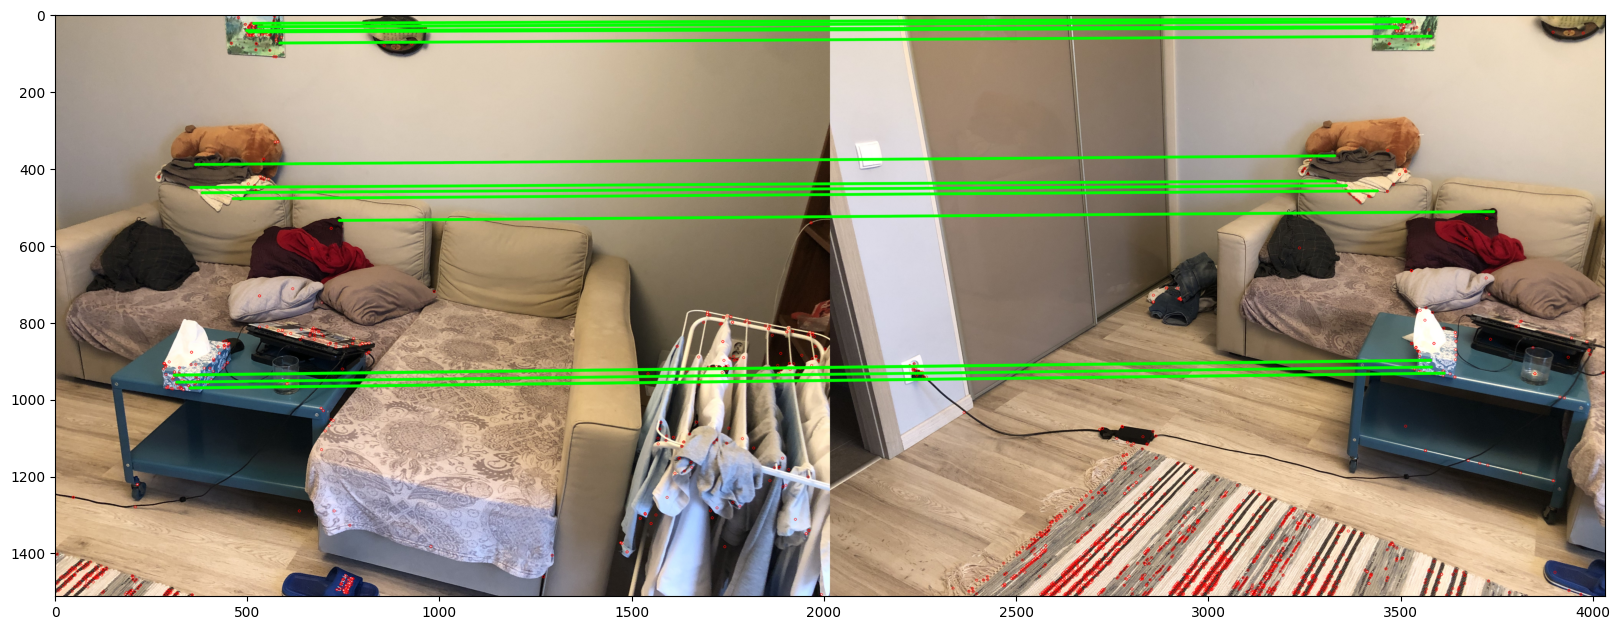

In [114]:
query = offset_imgs[0].copy()

contrastThreshold = 0.15
edgeThreshold = 10
distanceThreshold = 70

sift = cv2.SIFT_create(contrastThreshold=contrastThreshold, edgeThreshold=edgeThreshold)

keypoints1, descriptors1 = sift.detectAndCompute(base_img, mask=None)
keypoints2, descriptors2 = sift.detectAndCompute(query, mask=None)

bf = cv2.BFMatcher(cv2.NORM_L2)

matches = bf.knnMatch(descriptors1, descriptors2, k=2)
good_matches = []
for m in matches:
    if m[0].distance < 0.5 * m[1].distance:
        good_matches.append(m)
matches = np.asarray(good_matches)

image_matches_bf = cv2.drawMatches(
    base_img,
    keypoints1,
    query,
    keypoints2,
    matches[:, 0],
    None,
    matchesThickness=5,
    matchColor=(0, 255, 0),
    singlePointColor=(0, 0, 255),
)

plt.figure(figsize=(20, 15))
plt.imshow(cv2.cvtColor(image_matches_bf, cv2.COLOR_BGR2RGB))

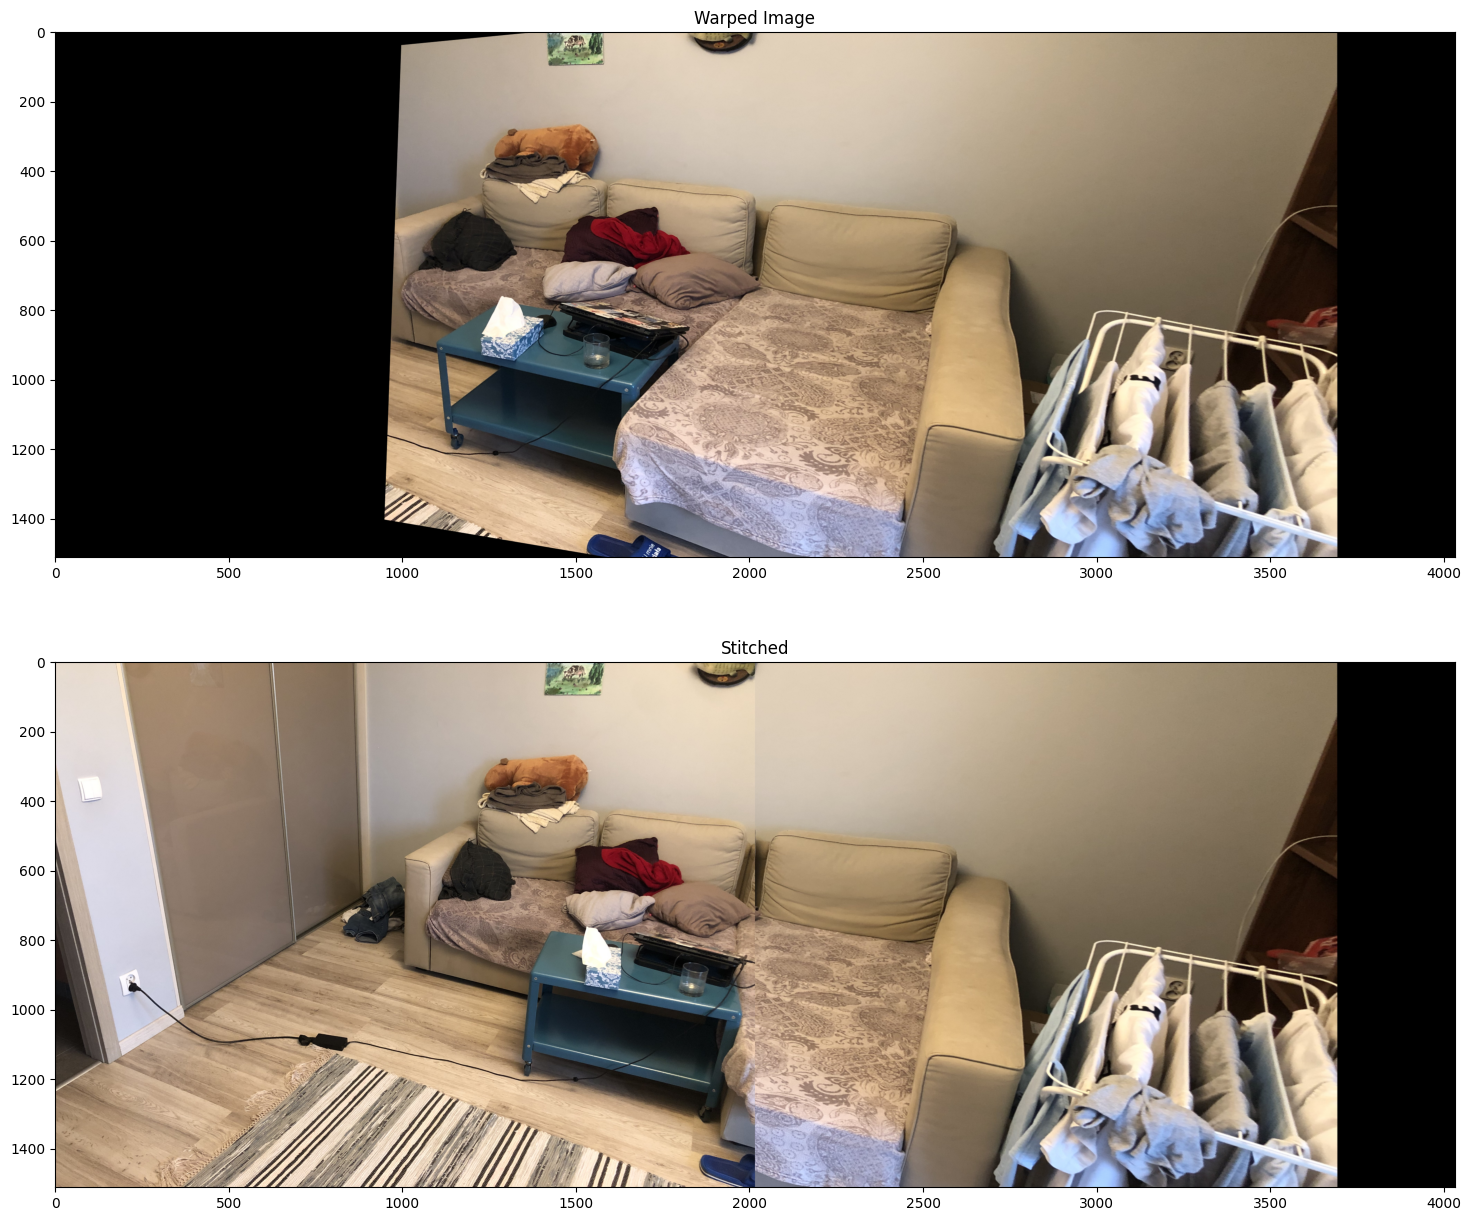

In [122]:
if len(matches[:, 0]) >= 4:
    src = np.float32([keypoints1[m.queryIdx].pt for m in matches[:, 0]]).reshape(
        -1, 1, 2
    )
    dst = np.float32([keypoints2[m.trainIdx].pt for m in matches[:, 0]]).reshape(
        -1, 1, 2
    )
    H, masked = cv2.findHomography(src, dst, cv2.RANSAC, 5.0)

    dst = cv2.warpPerspective(
        base_img, H, (base_img.shape[1] + query.shape[1], query.shape[0])
    )
    fig, ax = plt.subplots(2, 1, figsize=(20, 15))
    ax[0].imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
    ax[0].set_title("Warped Image")
    dst[0 : base_img.shape[0], 0 : base_img.shape[1]] = query
    ax[1].imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
    ax[1].set_title("Stitched")
else:
    raise AssertionError("Can't find enough keypoints.")